In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

import sys
sys.path.append("../src/")

from utils import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
## 읍면동 공간데이터 불러오기
emd = gpd.read_file(
    "../data/emd_20230729/emd.shp", 
    encoding="cp949", 
    )
emd = emd[emd["EMD_CD"].apply(lambda x: x[:2] == "48")]
emd = emd.set_crs(crs="EPSG:5179")
emd.head()

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
4147,48121101,Buk-dong,북동,"POLYGON ((1102045.846 1697454.541, 1102056.067..."
4148,48121102,Jung-dong,중동,"POLYGON ((1102971.896 1696610.962, 1102967.906..."
4149,48121103,Seosang-dong,서상동,"POLYGON ((1101865.625 1697403.568, 1101867.528..."
4150,48121104,Sodap-dong,소답동,"POLYGON ((1101600.798 1698518.248, 1101652.825..."
4151,48121105,Dogye-dong,도계동,"POLYGON ((1102967.906 1696606.655, 1102971.896..."


In [3]:
## 버스 정류장 위치 데이터
busstop = pd.read_csv(
    filepath_or_buffer="../data/busstop.csv", 
    encoding="cp949"
)

def cityname_preprocessor(x): 
    x_ = x.split()
    if x_[1] == "마산시" or x_[1] == "진해시":
        x_[1] = "창원시"
    return x_[1]

busstop = busstop[busstop["도시명"].apply(lambda x: True if "경상남도" in x else False)]
busstop["도시명"] = busstop["도시명"].apply(lambda x: cityname_preprocessor(x))

## 이상치 및 결측치 처리
busstop = busstop.drop(index=94785)
busstop.loc[140553, "위도"] = 34.927810
busstop.loc[140553, "경도"] = 128.06807
busstop.loc[140554, "위도"] = 34.927663
busstop.loc[140554, "경도"] = 128.06838

# busstop_usecol = ["정류장명", "위도", "경도", "도시명"]
busstop = busstop.reset_index(drop=True) # [busstop_usecol]

## geo data 형태로 변형
busstop = gpd.GeoDataFrame(
    busstop, 
    geometry=gpd.points_from_xy(busstop['경도'], busstop['위도'])
    )

## crs값 설정
busstop = busstop.set_crs(crs="EPSG:4326")
busstop = busstop.to_crs(epsg=5179)

In [4]:
## busstop데이터의 point만 추출
busstop_points = busstop[["geometry"]]
## emd데이터의 polygon만 추출
emd_polygons = emd[["geometry"]]

## 공간 join 수행 (points와 polygons 간의 'within' 관계를 기반으로)
busstop_within_emd = gpd.sjoin(
    left_df=busstop_points, 
    right_df=emd_polygons, 
    how='inner', 
    predicate='within'
    )

## joined DataFrame에는 points와 일치하는 polygons의 정보가 포함됨
busstop_within_emd = busstop_within_emd.drop(columns='index_right')

## 원본 버스 정류장 데이터에 조인
busstop_within_emd = gpd.sjoin(
    left_df=busstop, 
    right_df=busstop_within_emd, 
    how="right"
    ).drop(columns='index_left')
busstop_within_emd = busstop_within_emd.reset_index(drop=True)

In [5]:
# m_grid = folium.Map(location= [35.25, 128.25],tiles = 'OpenStreetMap' , zoom_start = 9)
# for i in busstop_within_emd[["위도", "경도"]].head(20).iterrows():
#     folium.Rectangle(get_bound(i[1]["위도"], i[1]["경도"]), color='red').add_to(m_grid)

# m_grid
    

In [6]:
import numpy as np
from shapely import Polygon

# 격자 생성 함수 정의
def create_grid(gdf, grid_size):
    bounds = gdf.total_bounds
    xmin, ymin, xmax, ymax = bounds
    rows = int(np.ceil((ymax - ymin) / grid_size))
    cols = int(np.ceil((xmax - xmin) / grid_size))
    
    x_left_origin = xmin
    x_right_origin = xmin + grid_size
    y_top_origin = ymax
    y_bottom_origin = ymax - grid_size
    polygons = []
    
    for i in range(cols):
        y_top = y_top_origin
        y_bottom = y_bottom_origin
        for j in range(rows):
            polygons.append(Polygon([(x_left_origin, y_top), 
                                     (x_right_origin, y_top), 
                                     (x_right_origin, y_bottom), 
                                     (x_left_origin, y_bottom)])) 
            y_top = y_top - grid_size
            y_bottom = y_bottom - grid_size
        x_left_origin = x_left_origin + grid_size
        x_right_origin = x_right_origin + grid_size

    grid = gpd.GeoDataFrame({'geometry':polygons})
    return grid

# 100m 격자 생성
grid_size = 100  # 100 meters
grid = create_grid(emd, grid_size)

In [10]:
# 격자와 지리 데이터 병합
grid.crs = emd.crs  # 좌표계 맞추기
grid = gpd.sjoin(grid, emd, how='inner', predicate='intersects')

# 예시 값 추가 (여기서는 임의의 값을 추가)
grid['value'] = np.random.randint(0, 100, size=len(grid))

ValueError: 'index_right' cannot be a column name in the frames being joined

KeyboardInterrupt: 

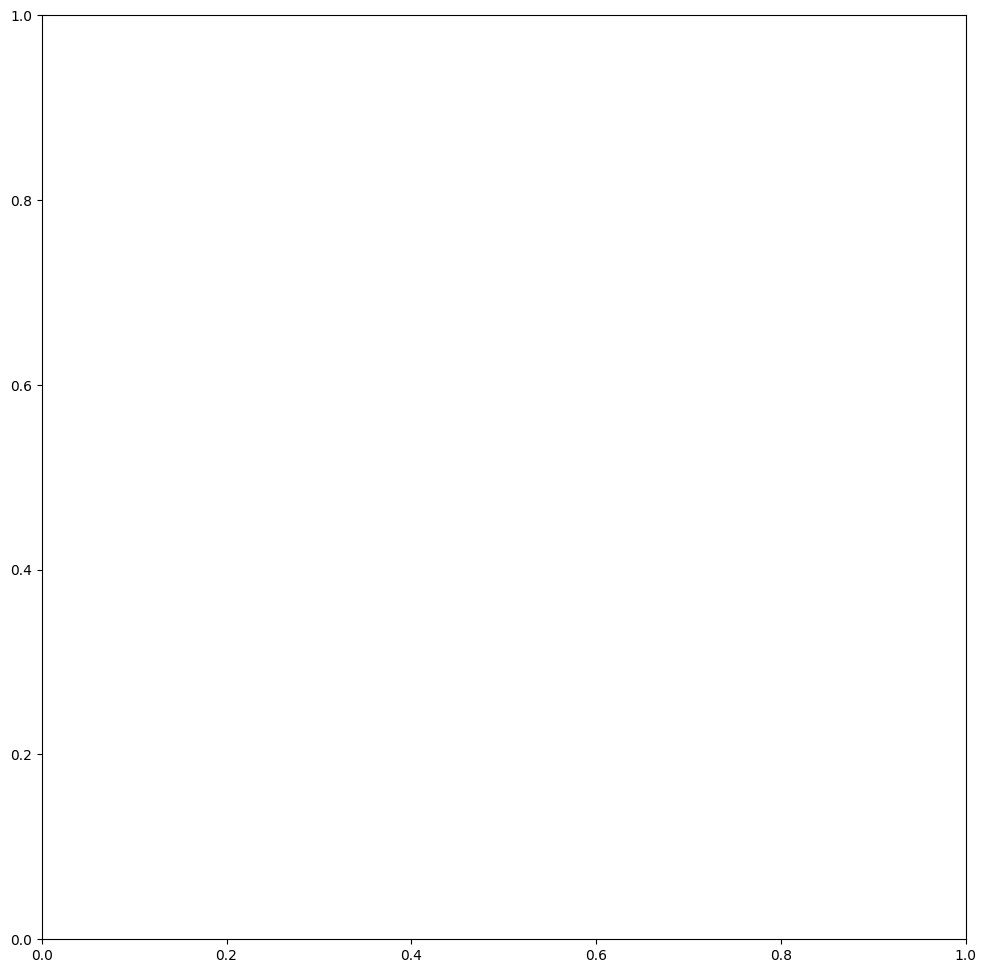

In [9]:
# 시각화
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
grid.plot(column='value', ax=ax, legend=True, cmap='viridis')
emd.boundary.plot(ax=ax, linewidth=1, color='black')

plt.title('Gyeongsangnam-do Grid Map with Values')
plt.show()

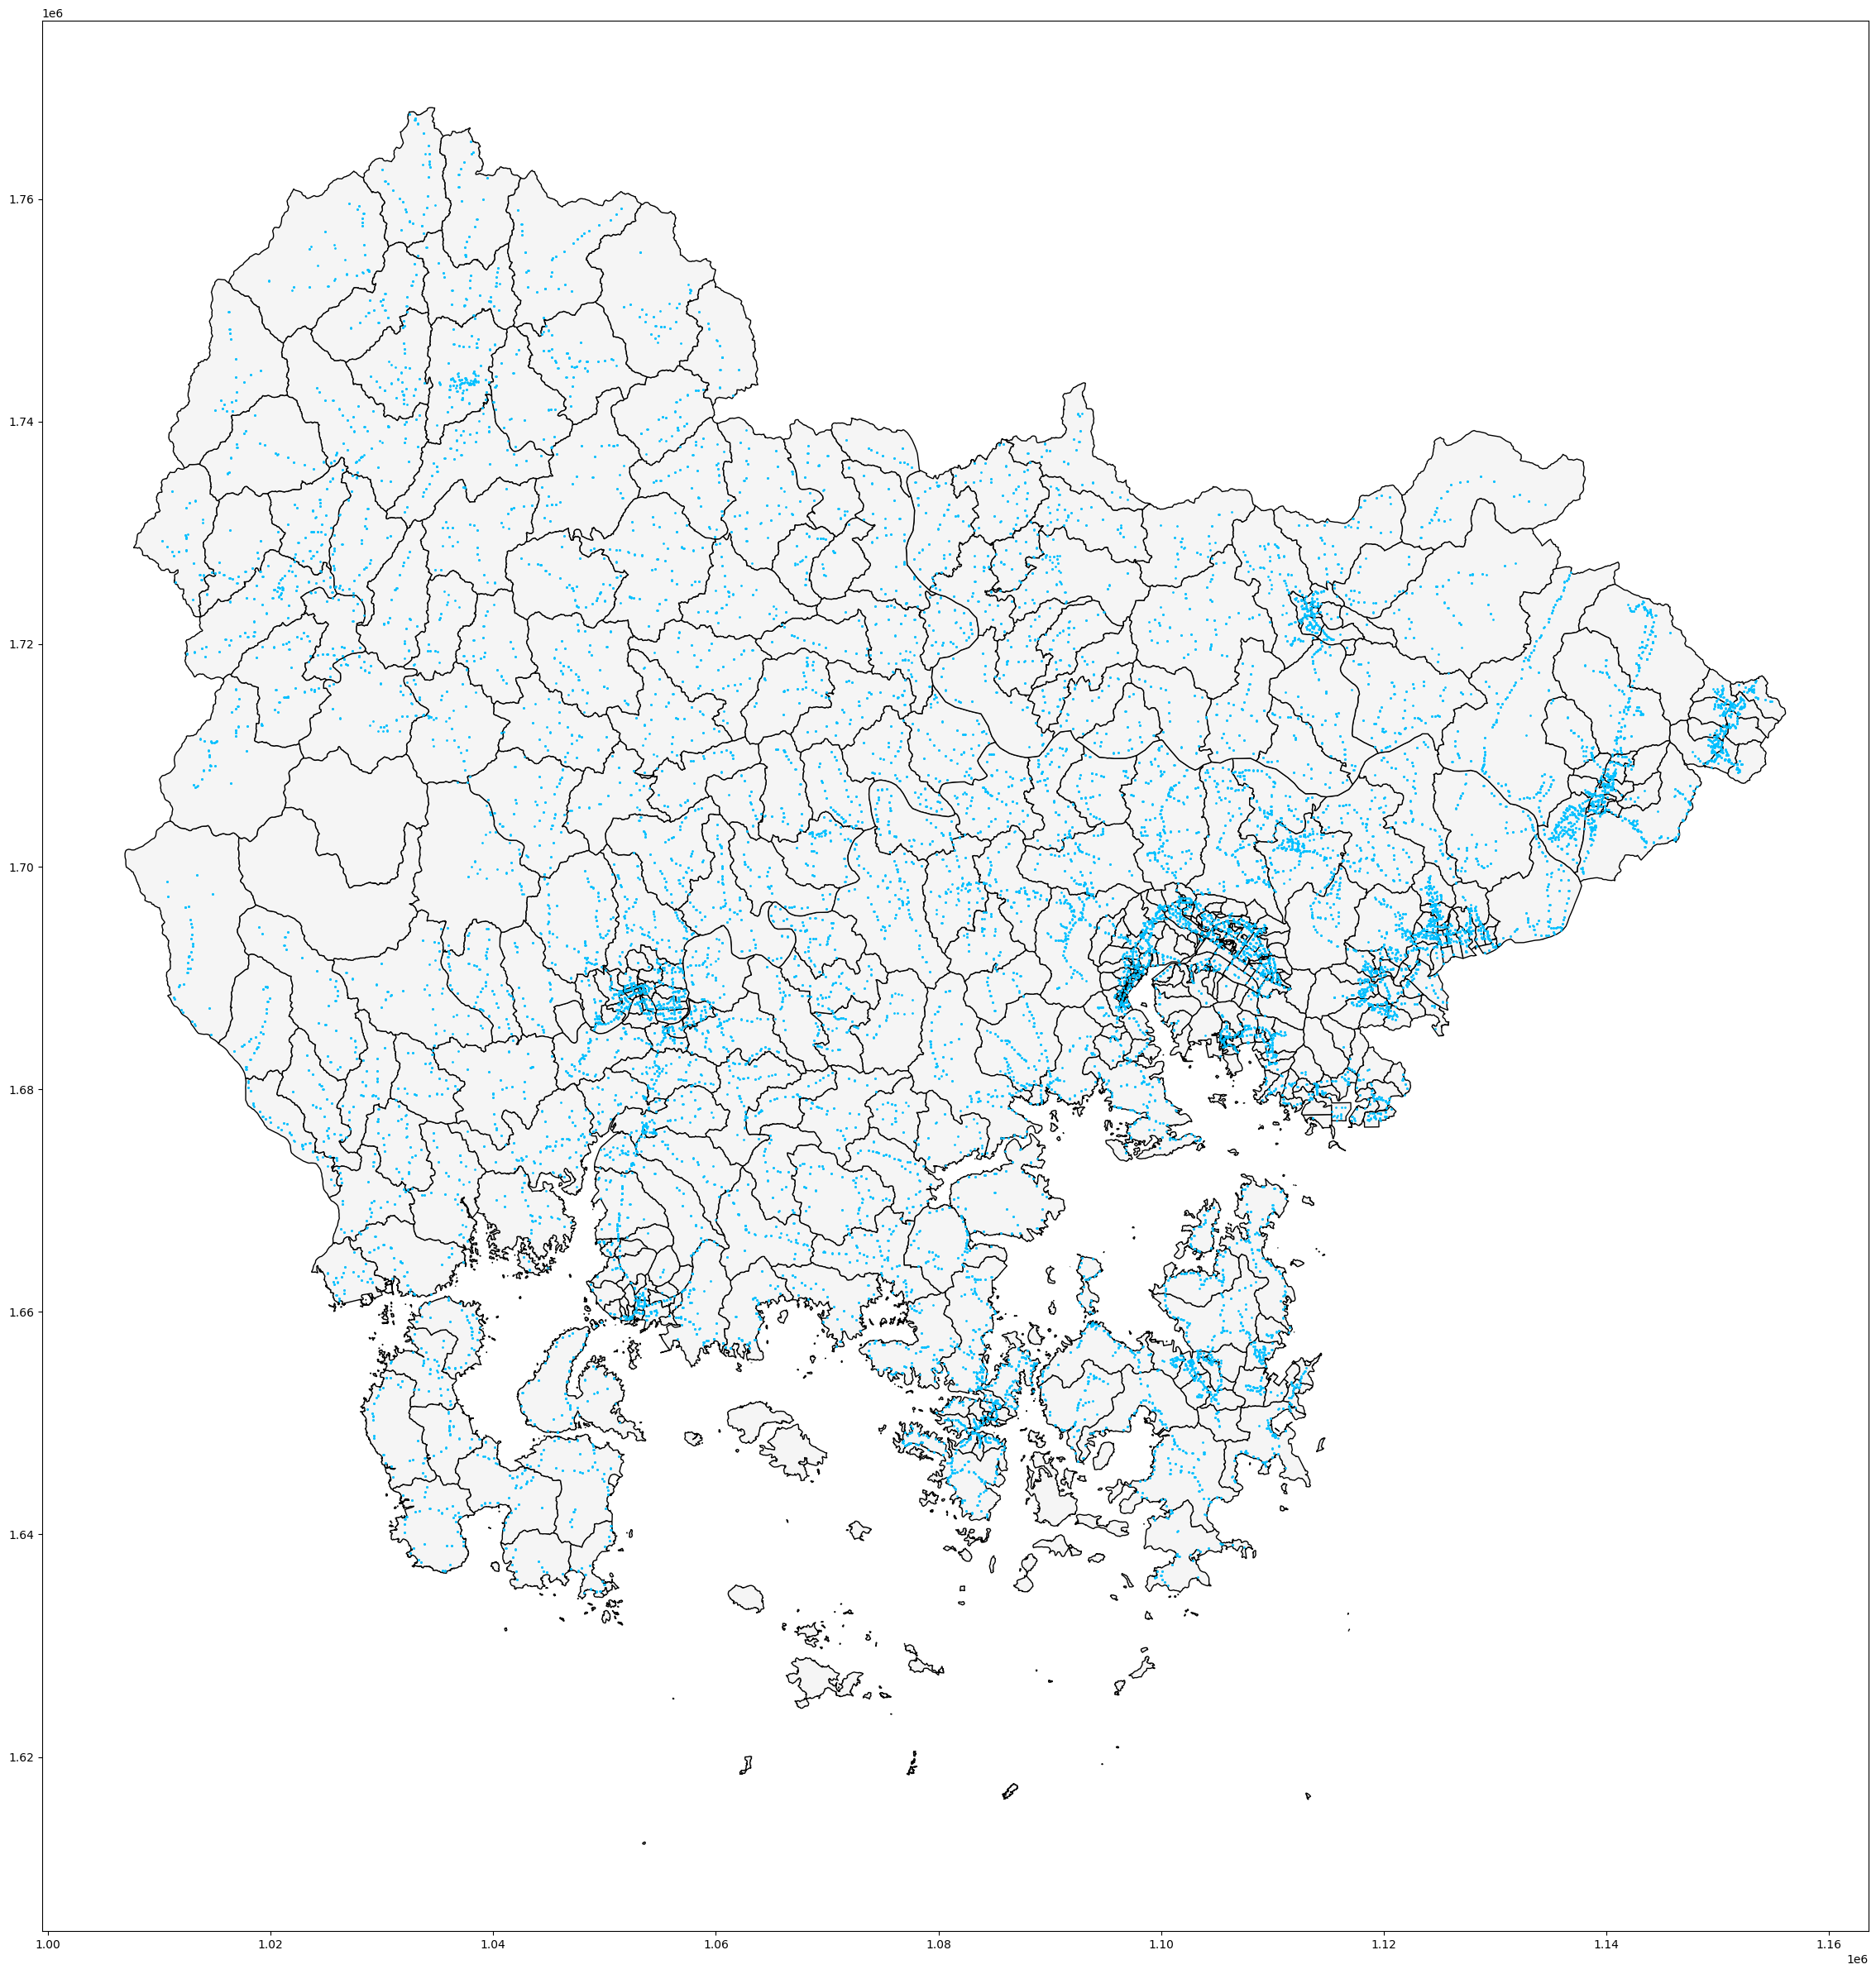

In [9]:
## 읍면동 틀 그리기
ax = emd.plot(
    figsize = (30, 30), 
    color = "whitesmoke", 
    edgecolor = "black", 
    linewidth = 1,
    column = "EMD_KOR_NM",
    legend = True, 
    categorical = True
)

## 버스 정류장 위치 확인
busstop_within_emd.plot(
    ax = ax, 
    color = "deepskyblue", 
    markersize = 1
)

plt.show()